In [167]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2
import random
import re
from torchvision.transforms import functional as F
from torchvision.ops.boxes import box_iou
import random

In [ ]:
# !pip install --upgrade albumentations
# import albumentations as A

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## Problems:
Seems like model never predict class 0 despite label.

## To Do: 

### Try to make the mAP integration in test function work with higher batch size than 1 do like 32 in test_loader
### Then copy that same logic to either a function and run it on the train_loader to check out its mAP and make sure it is higher than the test for now.
### Try to implement Other metrics

Try to Understand the concept of the metrics you apply. Currently, mAP.

 

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
###### Find and Download a lot more data that have bad spots and healthy etc. 


##### Add to the spreadsheet by getting info about agencies or research that is to help people who suffer from blindness.


## Links 
* Model: 
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
https://kaggle.com/kshitijpatil09/pytorch-mean-absolute-precision-calculation?scriptVersionId=40816383

* Metrics: 
https://manalelaidouni.github.io/manalelaidouni.github.io/Evaluating-Object-Detection-Models-Guide-to-Performance-Metrics.html#precision
* For Albumentations look at open source github
For Cropping 
https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/crops/transforms.py
https://github.com/albumentations-team/albumentations/blob/ae50578a46e5981eccaafee311a3ee0b4b7992b2/albumentations/augmentations/crops/functional.py#L22


##### Youtube Link 
https://www.youtube.com/watch?v=oqXDdxF_Wuw&ab_channel=Roboflow


# How to solve bad spots problem 
First run the fruit detector -> bouding box over every fruit. 
Then I will crop the image along the bouding box. 
Then run the cropped image through another bounding box detector and get object detection of bad_spots.

# Another solution 
Find Models that can work with neural network object detection crowding. 

#Another Solution
So I can remove the bad spot label and then have
["Apple", "Bad Apple", "Strawberry", "Bad Strawberry"] etc.

#Even another solution 
["Apple", "Specific Apple badspot"]
Like current model except differtiating against other black spots.

In [3]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Fruit Defects Dataset HalfWay.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [168]:
#For one strawberry batch please drop watermark rows
np.random.seed(42)
torch.manual_seed(42)
strawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/FreshStrawberryBatch3Labels.csv", header = None)
strawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberriesBatch2Labels.csv", header = None)
strawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/Strawberrybatch1.csv", header = None)
rottenApple_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch1Labeled/RottenAppleBatch1Labels.csv", header = None)
rottenApple_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApplesBatch2Labels.csv", header = None)
rottenApple_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/RottenApplesBatch3Labels.csv", header = None)
rottenStrawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch1RottenStrawBerryLabels/RottenStrawberriesBatch1Labels.csv", header = None)
rottenStrawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch2RottenStrawBerryLabels/RottenStrawBerryBatch2.csv", header = None)
rottenStrawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch3RottenStrawberrylabel/rottenStrawberryBtch3labels.csv", header = None)

strawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]

#Drop some watermark data for Fresh StrawBerry Batch 1 Labeled images [59, 9, 93]

# strawberry_csv_batch_1 = strawberry_csv_batch_1[Image_id not in ["FreshStrawberries59.jpeg, FreshStrawberries9.jpeg, FreshStrawberries93.jpeg"]]
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries59.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries9.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries93.jpeg"].index, inplace = True)
strawberry_csv_batch_1 = strawberry_csv_batch_1.reset_index(drop=True)

#Stack all the csv files together. 
list_of_all_dataframes = [strawberry_csv_batch_1, strawberry_csv_batch_2, strawberry_csv_batch_3, rottenApple_csv_batch_1, 
                          rottenApple_csv_batch_2, rottenApple_csv_batch_3, rottenStrawberry_csv_batch_1, rottenStrawberry_csv_batch_2, 
                          rottenStrawberry_csv_batch_3]
fruit_df = pd.concat(list_of_all_dataframes, ignore_index = True)

total_row_sum_check = 0 
for dataframe in list_of_all_dataframes:
  total_row_sum_check += dataframe.shape[0]
print("Checked total rows from all the dataframes combined: {}".format(total_row_sum_check))
def run_dataframe_check():
  assert total_row_sum_check == fruit_df.shape[0]
  print("DataFrame shape: {}".format(fruit_df.shape))
  print("Unique Fruit Labels {}".format(fruit_df["Fruit"].unique()))
  print("Number of Unique Images {}".format(len(fruit_df["Image_id"].unique())))

run_dataframe_check()

Checked total rows from all the dataframes combined: 844
DataFrame shape: (844, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Bad_Spots']
Number of Unique Images 246


In [5]:
#Specify more image types when 
def more_specific_Image_id(image_id, fruit):
  if fruit == "Bad_Spots":
    if re.search("RottenStrawberries", image_id):
      return "Strawberry_Bad_Spot"
    elif re.search("RottenApples", image_id):
      return "Apple_Bad_Spot"
    else:
      raise ValueError("Could not find a match for some of the Image_ids")

  else:
    return fruit

fruit_df["Fruit"] = fruit_df.apply(lambda row: more_specific_Image_id(row.Image_id, row.Fruit), axis = 1)

run_dataframe_check()

DataFrame shape: (844, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Apple_Bad_Spot' 'Strawberry_Bad_Spot']
Number of Unique Images 246


In [169]:
#Post Processing 
fruit_df = fruit_df[fruit_df["Image_id"] != "FreshStrawberries15.jpeg"]

In [170]:
bounding_box_dict = dict()
labels_dict = dict()
#classes = ["Strawberry", "Apples", "Apple_Bad_Spot", "Strawberry_Bad_Spot"]
classes = ["Bad_Spots", "Strawberry", "Apples"]

for row_index in range(len(fruit_df)): 
  current_image_file = fruit_df.iloc[row_index]["Image_id"]
  if current_image_file not in bounding_box_dict:
    bounding_box_dict[current_image_file] = list()
    labels_dict[current_image_file] = list()
  bounding_box_dict[current_image_file].append(fruit_df.iloc[row_index, 1:5].to_list())
  labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

print(len(bounding_box_dict))
print(len(labels_dict))

245
245


## Class function + util functions

In [171]:
def ffile_path(image_id, full_image_file_paths):
  for image_path in full_image_file_paths:
    if image_id in image_path:
      return image_path

def find_area_bb(bb_coord):
  bb_coord = bb_coord.numpy()
  area_of_each_bb = list()
  for pair_of_coord in bb_coord:
    area_of_each_bb.append(
        (pair_of_coord[2] - pair_of_coord[0]) * (pair_of_coord[3] - pair_of_coord[1])
    )
  return torch.tensor(area_of_each_bb, dtype=torch.int32)

def convert_min_max(bb_coord):
  for pair_of_coord in bb_coord:
    pair_of_coord[2], pair_of_coord[3] = (pair_of_coord[0] + pair_of_coord[-2]), (pair_of_coord[1] + pair_of_coord[-1])
  return bb_coord

class FruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms, mode):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())

    np.random.shuffle(self.imgs_key)
    if (mode == "train"):
      self.imgs_key = self.imgs_key[:int(len(self.imgs_key) * 0.8)]
    else:
      self.imgs_key = self.imgs_key[int(len(self.imgs_key) * 0.8):]

    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths)    
    img = Image.open(img_path).convert("RGB") ## No Image path sometimes
    boxes = convert_min_max(torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32))
    
    labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = find_area_bb(boxes)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    
    #Query about transforms for labels of images
    if self.transforms: 
      img, target = self.transforms(img, target)
    
    
    return img, target

  def __len__(self):
    return len(self.imgs_key)

In [172]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

In [174]:
#Using this stack overflow (https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders)
#(Suppose for example, you want to create batches of a list of varying dimension tensors. The below code pads sequences with 0 until the maximum sequence size of the batch,)
#Collate_fn is a function that is used to process your batches before you pass it to dataloader. In my case since I have different sized images I need a way to stack batches b/c torch.stack won't work.
#So I use zip which can accept tensors of different lengths and make them stacked with the size of the lowest length list given. Therefore stacking all the images in a batch 
#Successfully unlike torch.stack and doing that processing to every batch makes collate_fn vital since I have different image sizes.

def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])
    # return tuple(zip(*batch))

train_batch_size = 32
test_batch_size = 1

### Have to use augmentations to finally get train and test transforms
def get_transform(train):
    transform = []
    transform.append(ToTensor())
    if train:
        transform.append(RandomHorizontalFlip(0.5))
    return Compose(transform)

train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transform(train = False), mode = "train")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, collate_fn= collate_fn)

test_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transform(train = False), mode = "test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = test_batch_size, shuffle = True, collate_fn= collate_fn)


In [175]:
COLORS = [(255, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0)]

def draw_boxes(boxes, labels, image):
    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[labels[i]], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

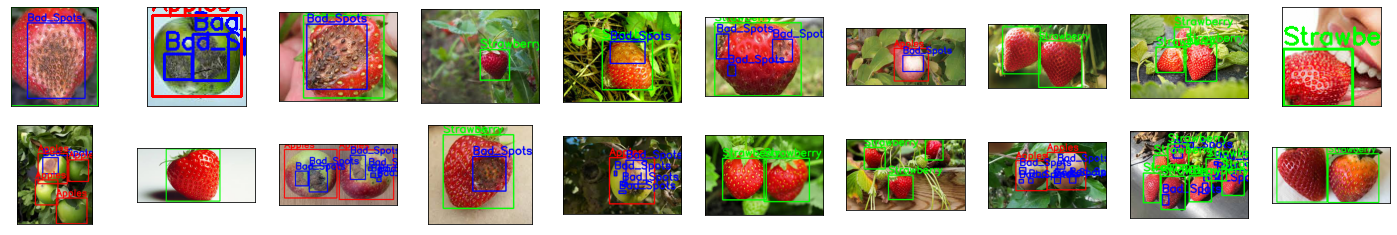

In [176]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = cv2.cvtColor(draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx]), cv2.COLOR_BGR2RGB)
    plt.imshow(image)

## What we learned
is that the model outputs losses when in train mode 
when in model.eval model, the model code then return only a prediction with no losses.

In [177]:
def calculate_mAP(target_box,predictions_box,scores, device, thresh= 0.1):

    #Get most confident boxes first and least confident last
    predictions_box = predictions_box[scores.argsort().flip(-1)]
    iou_mat = box_iou(target_box,predictions_box)
    #return a one by one matrix that is form (target_box, prediction_box) or (1, 1)
    target_boxes_count, prediction_boxes_count = iou_mat.shape
    # thresh = torch.tensor(thresh).to(device)
    
    # thresholding
    # iou_mat = iou_mat.where(iou_mat>thresh,torch.tensor(0.))
    
    mAP_Matrix = torch.zeros_like(iou_mat)
    # if not matrix coordinates that relate to nothing.
    if not iou_mat[:,0].eq(0.).all():
      index_of_biggest_iou = iou_mat[:,0].argsort()[-1]
      mAP_Matrix[index_of_biggest_iou,0] = 1

    for pr_idx in range(1,prediction_boxes_count):
        not_assigned = torch.logical_not(mAP_Matrix[:,:pr_idx].sum(1)).long()
        targets = not_assigned * iou_mat[:,pr_idx]

        if targets.eq(0).all():
            continue

        pivot = targets.argsort()[-1]
        mAP_Matrix[pivot,pr_idx] = 1

    # mAP calculation
    tp = mAP_Matrix.sum()
    fp = mAP_Matrix.sum(0).eq(0).sum()
    fn = mAP_Matrix.sum(1).eq(0).sum()
    mAP = tp / (tp+fp+fn)
    # mAP = tp / (tp + fp)
    # mAR = tp / (tp + fn)
    
    return mAP

In [178]:
def train(net, epochs, train_loader, test_loader, lr, print_every = 6, lo_test_dataset = len(test_dataset)):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Check which parameters can calulate gradients. 
    params = [p for p in net.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr = lr)

    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    
    start_time = time.time()
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = steps = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            net.train()

            steps += 1

            images = [image.to(device) for image in images]
            targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

            optimizer.zero_grad()
            
            loss_dict = net(images, targets)

            losses = sum(loss for loss in loss_dict.values())
                
            losses.backward()
            optimizer.step()

            train_loss +=  losses.item()

            if (steps % print_every) == 0:

              net.eval()
              with torch.no_grad():
                test_mAP = 0
                missed_images = 0

                for images, targets in test_loader:
                  """ Make sure the batch size is one (for now) for test loader due to sometimes there being empty predictions"""
                  if device == torch.device("cuda"):
                    images = [image.to(device) for image in images]
                    targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

                  ### Run the output on every individual image or change batch_size to 1 then get the output.
                  output = net(images)
                  
                  assert (len(output[0]["boxes"]) == len(output[0]["labels"]) == len(output[0]["scores"]))


                  if len(output[0]["boxes"]) != 0:
                    test_mAP += calculate_mAP(targets[0]["boxes"], output[0]["boxes"], output[0]["scores"], device) 
                  else:
                    missed_images += 1

                print("Epoch {}/{} | Batch Number: {} | Train_loss: {:0.2f} | mAP: {:0.2f}% | Missed Images: {}".format(epoch + 1, epochs, steps, train_loss, 
                                                                                                                        (test_mAP / lo_test_dataset) * 100., 
                                                                                                                        missed_images))
              assert (steps % print_every) == 0
              train_loss = 0
              net.train()

        # print("Epoch {} | Train_loss: {:0.2f} | mAP: {:0.2f}% | Missed Images: {}".format(epoch + 1, train_loss, 
        #                                                                                  (test_mAP / lo_test_dataset) * 100., 
        #                                                                                  missed_images))
    
    print("Time for Total Training {:0.2f}".format(time.time() - start_time))
    return net


## This link shows the problem https://github.com/pytorch/vision/issues/2740
The answer from @oke-aditya is correct. You are probably passing to the model bounding boxes in the format [xmin, ymin, width, height], while Faster R-CNN expects boxes to be in [xmin, ymin, xmax, ymax] format.

Changing this should fix the issue.

We have btw recently added box conversion utilities to torchvision (thanks to @oke-aditya ), they can be found in

Look at box convert or doing it locally also works.

### https://github.com/pytorch/vision/blob/a98e17e50146529cdfadb590ba063e6bbee71de2/torchvision/ops/boxes.py#L137-L156




In [179]:
import torchvision
backbone = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=False)
# backbone.roi_heads.box_predictor.cls_score.out_features = 4
# backbone.roi_heads.box_predictor.bbox_pred.out_features = 16
backbone.roi_heads.box_predictor.cls_score.out_features = 3
backbone.roi_heads.box_predictor.bbox_pred.out_features = 12


In [180]:
another_one = train(backbone, 10, train_loader, test_loader, 0.001)

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Epoch 1/10 | Batch Number: 6 | Train_loss: 75.19 | mAP: 7.48% | Missed Images: 0
Epoch 2/10 | Batch Number: 6 | Train_loss: 24.23 | mAP: 10.78% | Missed Images: 7
Epoch 3/10 | Batch Number: 6 | Train_loss: 4.83 | mAP: 12.48% | Missed Images: 1
Epoch 4/10 | Batch Number: 6 | Train_loss: 4.32 | mAP: 11.53% | Missed Images: 17
Epoch 5/10 | Batch Number: 6 | Train_loss: 3.31 | mAP: 2.61% | Missed Images: 26
Epoch 6/10 | Batch Number: 6 | Train_loss: 3.31 | mAP: 13.65% | Missed Images: 1
Epoch 7/10 | Batch Number: 6 | Train_loss: 3.51 | mAP: 13.51% | Missed Images: 16
Epoch 8/10 | Batch Number: 6 | Train_loss: 3.05 | mAP: 20.69% | Missed Images: 13
Epoch 9/10 | Batch Number: 6 | Train_loss: 3.19 | mAP: 14.56% | Missed Images: 3
Epoch 10/10 | Batch Number: 6 | Train_loss: 3.01 | mAP: 13.97% | Missed Images: 1
Time for Total Training 74.22


In [ ]:
def calculate_bounding_metrics():
  

In [181]:
def infer_image(image_file_path, trained_model, distance_thresh, show_image = True):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Current device: {}".format(device))

  torch_image = F.to_tensor(Image.open(image_file_path).convert("RGB")).unsqueeze(0).to(device)
  trained_model.to(device)
  trained_model.eval()
  print("Image Size: {}".format(torch_image.size()))

  results = trained_model(torch_image)
  print(results)


  valid_box_count = 0
  for ii, score in enumerate(results[0]["scores"]):
    if score < distance_thresh:
      low_index_start = ii
      break
    else:
      valid_box_count += 1

  if valid_box_count == len(results[0]["scores"]):
    low_index_start = len(results[0]["scores"])
  

  for key in results[0]:
    results[0][key] = results[0][key][:low_index_start]

  if show_image:
    if device == torch.device("cuda"):
      torch_image = torch_image.cpu() 
    plt.imshow(cv2.cvtColor(draw_boxes(results[0]["boxes"], results[0]["labels"], torch_image.squeeze()), cv2.COLOR_BGR2RGB))
  
  return results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 275, 183])
[{'boxes': tensor([[ 34.8712,  46.0741, 183.0000, 196.4321],
        [135.3398,  13.3362, 183.0000,  85.5798],
        [ 54.9756, 122.2003, 149.3411, 205.0464],
        [102.9173,  67.0563, 177.8948, 145.4946],
        [108.8997,  88.4534, 146.8804, 130.6535],
        [ 48.3452,  68.7441, 156.0182, 150.7358],
        [ 82.2390,  79.0479, 183.0000, 226.3813],
        [113.3300,  20.8129, 183.0000, 172.1346],
        [128.1405,  38.9358, 183.0000, 116.0080],
        [144.4222,  48.4467, 183.0000,  97.5399],
        [110.6524, 212.7283, 183.0000, 275.0000],
        [ 87.7686, 137.0079, 127.9970, 184.6702],
        [144.6890,  69.0172, 181.9967, 112.5923],
        [ 69.2015,  48.0519, 177.8770, 128.9966],
        [146.6256,  87.6350, 183.0000, 135.5346],
        [ 36.5551, 208.2130, 135.2692, 275.0000],
        [ 68.8130, 137.4600, 111.1766, 184.6882],
        [ 69.3447, 105.0059, 169.8954, 188.1591],
        [ 79.2398, 140.8713

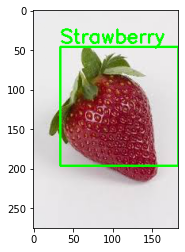

In [194]:
first_results = infer_image("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/FreshStrawberries87.jpeg", 
            another_one, 0.2)
print(first_results)

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

#Got this code from Pytorch
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes= 3,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [ ]:
big_model_trained = train(model, 5, train_loader, 0.001)

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Train_loss 75.02
Train_loss 51.36
Train_loss 46.14
Train_loss 41.43
Train_loss 41.80
Time for Total Training 239.89
